<a href="https://colab.research.google.com/github/Shoaibaqeel/Deep-Learning-Practice/blob/main/Assignment_3_Facial_Exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 66% 40.0M/60.3M [00:00<00:00, 214MB/s]
100% 60.3M/60.3M [00:00<00:00, 227MB/s]


In [ ]:
import zipfile
zip = zipfile.ZipFile("/content/fer2013.zip",'r')
zip.extractall("/content")
zip.close()

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

**Augmentation**

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range = 15,
    width_shift_range = 10,
    height_shift_range = 10,
    shear_range = 0.15,
    zoom_range = 0.15,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [ ]:
train_ds = train_datagen.flow_from_directory(
    directory = '/content/train',
    color_mode = 'grayscale',
    class_mode = 'categorical',
    batch_size=32,
    target_size=(48,48)
)

Found 28709 images belonging to 7 classes.


In [ ]:
validation_ds = test_datagen.flow_from_directory(
    directory = '/content/test',
    color_mode = 'grayscale',
    class_mode = 'categorical',
    batch_size=32,
    target_size=(48,48)
)

Found 7178 images belonging to 7 classes.


In [ ]:
class_names = list(train_ds.class_indices.keys())
print(class_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


Class [0 1 2 3 4 5 6]
Count [3995  436 4097 7215 4965 4830 3171]



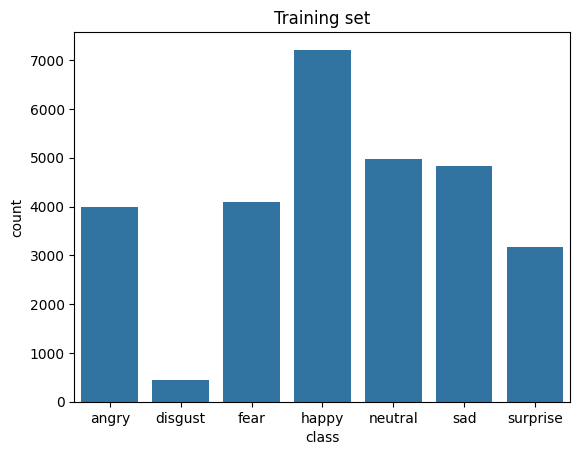

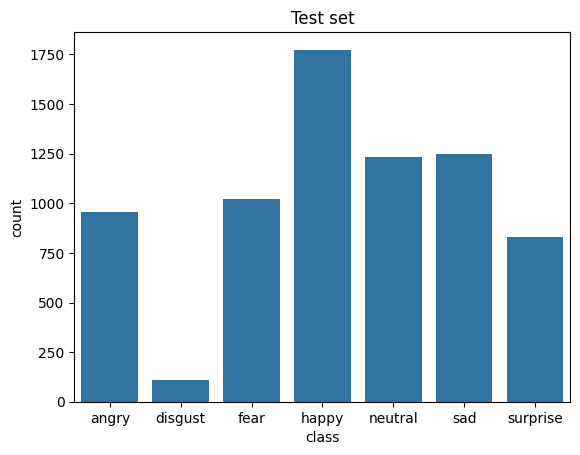

In [ ]:
train_class = np.unique(train_ds.classes, return_counts = True)
test_class = np.unique(validation_ds.classes, return_counts = True)
print("Class", train_class[0])
print("Count", train_class[1])
print()

plt.figure()

sns.barplot(x = class_names, y = train_class[1])

plt.title("Training set")
plt.xlabel('class')
plt.ylabel('count')
plt.show()

sns.barplot(x = class_names, y = test_class[1])

plt.title("Test set")
plt.xlabel('class')
plt.ylabel('count')
plt.show()

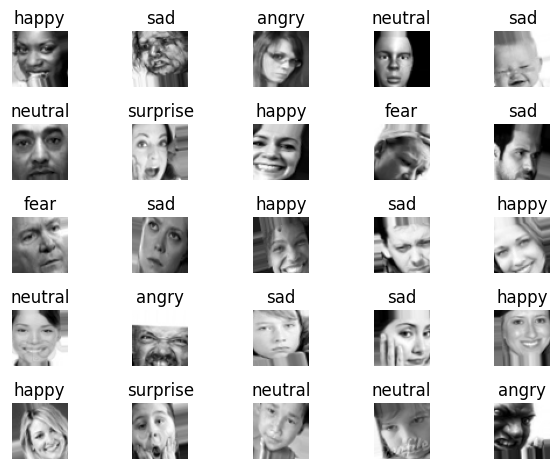

In [ ]:
fig, axes = plt.subplots(ncols = 5, nrows = 5)
axes = axes.flatten()

for i in range(25):
    j = np.random.randint(train_ds.n)

    # take data
    batch_images, batch_labels = train_ds[j // 32]
    id_in_batch = j % 32
    image = batch_images[id_in_batch]
    label = batch_labels[id_in_batch].argmax()

    # show data
    axes[i].imshow(image, cmap = "gray")
    axes[i].set_title(class_names[label])
    axes[i].axis("off")

plt.tight_layout()
plt.show()

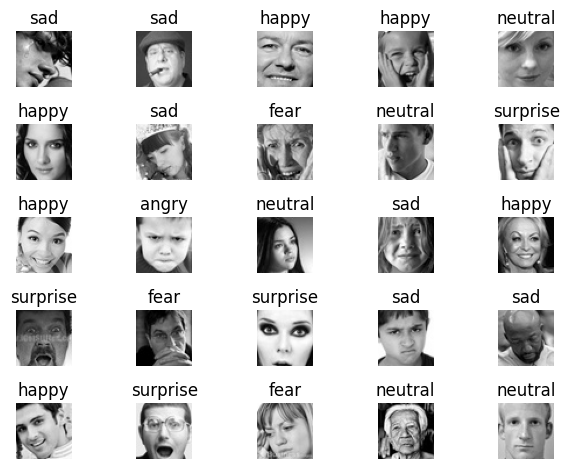

In [ ]:
fig, axes = plt.subplots(ncols = 5, nrows = 5)
axes =axes.flatten()

for i in range(25):
    j = np.random.randint(validation_ds.n)

    # take data
    batch_images, batch_labels = validation_ds[j // 32]
    id_in_batch = j % 32
    image = batch_images[id_in_batch]
    label = batch_labels[id_in_batch].argmax()

    # show data
    axes[i].imshow(image, cmap = "gray")
    axes[i].set_title(class_names[label])
    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# create CNN model

model = Sequential()

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(256,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(512,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(7,activation='softmax'))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 46, 46, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 21, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 21, 21, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 2, 2, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 2, 2, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 2,382,983 (9.09 MB)

 Trainable params: 2,381,063 (9.08 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 53s 47ms/step - accuracy: 0.2584 - loss: 1.8033 - val_accuracy: 0.2955 - val_loss: 1.7201
Epoch 2/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 62s 32ms/step - accuracy: 0.3514 - loss: 1.6386 - val_accuracy: 0.4131 - val_loss: 1.5056
Epoch 3/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 29s 32ms/step - accuracy: 0.3984 - loss: 1.5377 - val_accuracy: 0.4305 - val_loss: 1.4568
Epoch 4/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 28s 31ms/step - accuracy: 0.4379 - loss: 1.4574 - val_accuracy: 0.4890 - val_loss: 1.3628
Epoch 5/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 28s 31ms/step - accuracy: 0.4689 - loss: 1.3924 - val_accuracy: 0.5227 - val_loss: 1.2526
Epoch 6/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 29s 32ms/step - accuracy: 0.4843 - loss: 1.3424 - val_accuracy: 0.5461 - val_loss: 1.1915
Epoch 7/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 29s 32ms/step - accuracy: 0.4961 - loss: 1.3025 - val_accuracy: 0.5343 - val_loss: 1.2150
Epoch 8/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - accuracy: 0.5175 - loss: 1.2739 - val_accurac

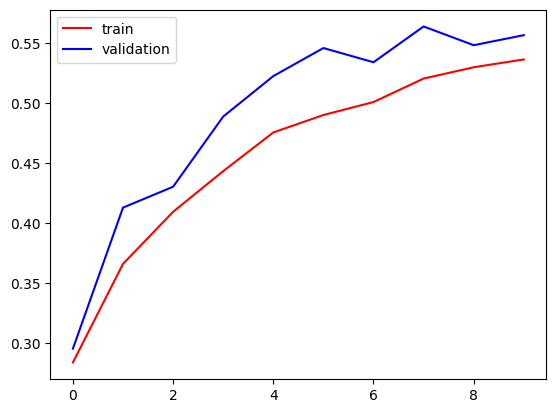

In [ ]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

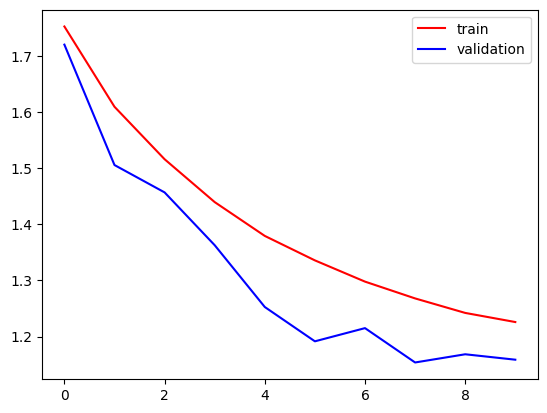

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
# Evaluate the Model

print("Evaluating the model...")

# Evaluate on the training data
train_loss, train_acc = model.evaluate(train_ds, verbose=0)

# Evaluate on the test (validation) data
test_loss, test_acc = model.evaluate(validation_ds, verbose=0)

# Print the evaluation results in a concise format
print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%")

Evaluating the model...
Training Loss: 1.2997, Training Accuracy: 51.22%
Test Loss: 1.1588, Test Accuracy: 55.68%


In [ ]:
predictions = model.predict(validation_ds)
predicted_classes = np.argmax(predictions, axis=1)
labels = validation_ds.classes
class_labels = list(validation_ds.class_indices.keys())

225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step


In [ ]:
print("\nClassification Report:")
print(classification_report(labels, predicted_classes, target_names=class_labels))



Classification Report:
              precision    recall  f1-score   support

       angry       0.14      0.09      0.11       958
     disgust       0.00      0.00      0.00       111
        fear       0.16      0.06      0.08      1024
       happy       0.24      0.35      0.29      1774
     neutral       0.17      0.26      0.20      1233
         sad       0.19      0.15      0.17      1247
    surprise       0.13      0.12      0.12       831

    accuracy                           0.19      7178
   macro avg       0.15      0.15      0.14      7178
weighted avg       0.18      0.19      0.18      7178



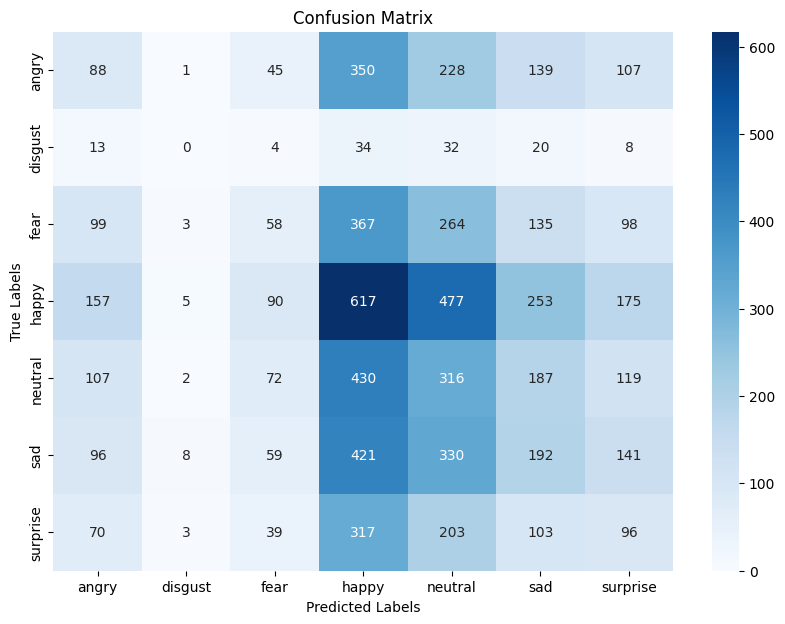

In [ ]:
cm = confusion_matrix(labels, predicted_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels
)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

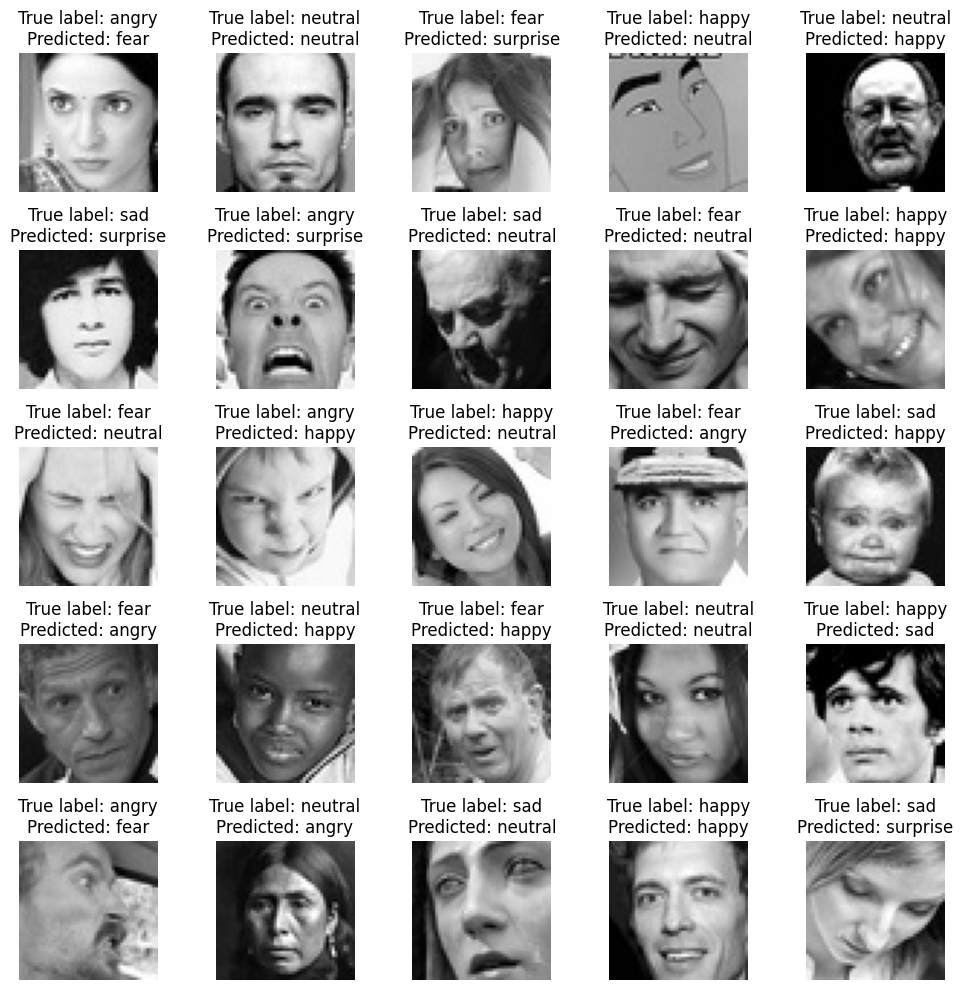

In [35]:
fig, axes = plt.subplots(ncols = 5, nrows = 5, figsize = (10, 10))
axes =axes.flatten()

for i in range(25):
    j = np.random.randint(validation_ds.n)

    # take data
    batch_images, batch_labels = validation_ds[j // 32]
    id_in_batch = j % 32
    image = batch_images[id_in_batch]
    label = batch_labels[id_in_batch].argmax()

    # show data
    axes[i].imshow(image, cmap = "gray")
    axes[i].set_title(f"True label: {class_names[label]}\nPredicted: {class_names[predicted_classes[j]]}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

Data is severly imbalanced causing biasness toward the emotion "Happy" while the emotion "Disgust" is completely overlooked.


In [33]:
from tensorflow.keras.preprocessing import image
import os

def predict_img(file_name,model):
    if os.path.isdir(file_name):
        for filename in os.listdir(file_name):
            # Construct the full path to the image file
            image_path = os.path.join(file_name, filename)
            img=image.load_img(image_path,target_size=(48,48))
            img_array=image.img_to_array(img)
            img_array/=255
            img_pred=model.predict(img_array)
            index = np.argmax(img_pred)

            plt.title("Prediction - {}".format(str(class_names[index]).title()), size=18, color='red')
            plt.imshow(img_array, cmap = "gray")
            plt.show()

        else:
            img = image.load_img(file_name, target_size=(48, 48))
            img_array = image.img_to_array(img)
            img_array /= 255
            img_pred=model.predict(img_array)
            index = np.argmax(img_pred)

            plt.title("Prediction - {}".format(str(class_names[index]).title()), size=18, color='red')
            plt.imshow(img_array, cmap = "gray")
            plt.show()

In [34]:
predict_img('/content/train/angry/Training_10118481.jpg', model)